In [79]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import causalgraphicalmodels as cgm
import graphviz as gv
import os
from theano import *
import theano.tensor as T
#os.environ["PATH"] += os.pathsep + 'C:/Users/mikev/Anaconda3/envs/stats/Library/bin/graphviz'
os.environ["PATH"] += os.pathsep + 'C:/Users/mviotti/AppData/Local/Continuum/anaconda3/envs/stats/Library/bin/graphviz'

In [2]:
# I'm going to skip everything about leg length. I get the point - it's just not worth
# writing the code, I don't think.

In [3]:
#R code 6.8
d = pd.read_csv('Data/milk.csv', sep=';', header=0)
d['k_s'] = (d['kcal.per.g'] - d['kcal.per.g'].mean())/d['kcal.per.g'].std()
d['n_s'] = (d['neocortex.perc'] - d['neocortex.perc'].mean())/d['neocortex.perc'].std()
d['m_s'] = (np.log(d.mass) - np.log(d.mass).mean())/np.log(d.mass).std()
d['f_s'] = (d['perc.fat'] - d['perc.fat'].mean())/d['perc.fat'].std()
d['l_s'] = (d['perc.lactose'] - d['perc.lactose'].mean())/d['perc.lactose'].std()

In [4]:
#R code 6.9
with pm.Model() as m_6_3: #using 6_3 to align with text
    alpha = pm.Normal('alpha', mu=0, sd=0.2) 
    beta_fat = pm.Normal('beta_fat', mu=0, sd=0.5) 
    mu = pm.Deterministic('mu', alpha + beta_fat*d.f_s)
    sigma = pm.Exponential('sigma', 1)
    K = pm.Normal('kcalpg', mu=mu, sd=sigma, observed=d.k_s)
    trace_6_3 = pm.sample(1000, tune=1000, chains=1) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_fat, alpha]
100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1058.08it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [5]:
#R code 6.9 continued
with pm.Model() as m_6_4:
    alpha = pm.Normal('alpha', mu=0, sd=0.2) 
    beta_lactose = pm.Normal('beta_lactose', mu=0, sd=0.5) 
    mu = pm.Deterministic('mu', alpha + beta_lactose*d.l_s)
    sigma = pm.Exponential('sigma', 1)
    K = pm.Normal('kcalpg', mu=mu, sd=sigma, observed=d.k_s)
    trace_6_4 = pm.sample(1000, tune=1000, chains=1) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_lactose, alpha]
100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1329.34it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [6]:
varnames = ['alpha', 'beta_fat','sigma']
pm.summary(trace_6_3, var_names = varnames, alpha = 0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5
alpha,-0.00,0.08,0.0,-0.13,0.14
beta_fat,0.86,0.09,0.0,0.73,1.01
sigma,0.49,0.07,0.0,0.38,0.59


In [7]:
varnames = ['alpha', 'beta_lactose','sigma']
pm.summary(trace_6_4, var_names = varnames, alpha = 0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5
alpha,-0.00,0.07,0.0,-0.12,0.11
beta_lactose,-0.90,0.08,0.0,-1.02,-0.78
sigma,0.41,0.06,0.0,0.33,0.51


In [8]:
#R code 6.10
with pm.Model() as m_6_5:
    alpha = pm.Normal('alpha', mu=0, sd=0.2) 
    beta_lactose = pm.Normal('beta_lactose', mu=0, sd=0.5) 
    beta_fat = pm.Normal('beta_fat', mu=0, sd=0.5) 
    mu = pm.Deterministic('mu', alpha + beta_lactose*d.l_s + beta_fat*d.f_s)
    sigma = pm.Exponential('sigma', 1)
    K = pm.Normal('kcalpg', mu=mu, sd=sigma, observed=d.k_s)
    trace_6_4 = pm.sample(1000, tune=1000, chains=1) 

varnames = ['alpha', 'beta_lactose', 'beta_fat', 'sigma']
pm.summary(trace_6_4, var_names = varnames, alpha = 0.11).round(2)
# Punch line: now each predictor is less valuable than it was in its bivariate model. The cause: the two 
# predictors are very highly correlated. Once you know one, there is very little value in knowing the other.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_fat, beta_lactose, alpha]
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 629.27it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


,mean,sd,mc_error,hpd_5.5,hpd_94.5
alpha,0.00,0.08,0.00,-0.13,0.11
beta_lactose,-0.66,0.20,0.01,-0.95,-0.34
beta_fat,0.26,0.20,0.01,-0.05,0.56
sigma,0.42,0.05,0.00,0.33,0.50


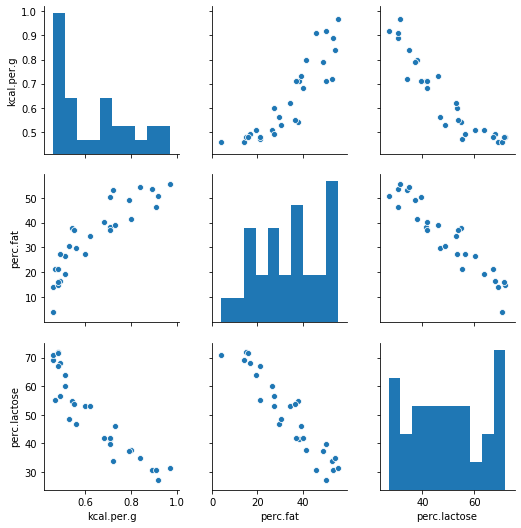

In [9]:
#R code 6.11
df = d[['kcal.per.g','perc.fat','perc.lactose']]
sns.pairplot(df);

In [10]:
#R code 6.12
d.corr()['perc.fat']['perc.lactose']
# very strongly correlated

-0.9416373456839282

In [11]:
#R code 6.14

N = 100 # number of plants
h_0 = stats.norm.rvs(loc=10, scale=2, size = N) #simulate initial heights
treatment = np.repeat([0,1], [N/2]) #treat half the plants
fungus = stats.binom.rvs(size = N, n=1, p=(0.5 -  treatment*0.4)) # fungus results
h_1 = h_0 + stats.norm.rvs(size=N, loc=(5-3*fungus)) #final height
d = pd.DataFrame({'h_0': h_0,
                  'h_1': h_1,
                  'treatment':treatment,
                  'fungus': fungus})

#this 'data' will inform our priors for the next model

In [12]:
#R code 6.16
with pm.Model() as m_6_6:
    p = pm.Lognormal('proportion', mu=0, sd=0.25) 
    mu = pm.Deterministic('mu', p*d.h_0)
    sigma = pm.Exponential('sigma', 1)
    h_1 = pm.Normal('h_1', mu=mu, sd=sigma, observed=d.h_1)
    trace_6_6 = pm.sample(1000, tune=1000, chains=1) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, proportion]
100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1994.28it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [13]:
varnames = ['proportion','sigma']
pm.summary(trace_6_6, var_names = varnames, alpha = 0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5
proportion,1.35,0.02,0.0,1.32,1.38
sigma,2.13,0.14,0.0,1.91,2.36


In [14]:
#R code 6.17
with pm.Model() as m_6_7:
    alpha = pm.Lognormal('alpha', mu=0, sd=0.25) #note alpha here is the old p
    beta_treatment = pm.Normal('beta_treatment', mu=0, sd=0.5) 
    beta_fungus = pm.Normal('beta_fungus', mu=0, sd=0.5) 
    p = pm.Deterministic('proportion', alpha + beta_treatment * d.treatment + beta_fungus * d.fungus)
    mu = pm.Deterministic('mu', p*d.h_0)
    sigma = pm.Exponential('sigma', 1)
    h_1 = pm.Normal('h_1', mu=mu, sd=sigma, observed=d.h_1)
    trace_6_7 = pm.sample(1000, tune=1000, chains=1) 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_fungus, beta_treatment, alpha]
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 847.19it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [15]:
varnames = ['alpha','beta_treatment','beta_fungus','sigma']
pm.summary(trace_6_7, var_names = varnames, alpha = 0.11).round(2)
# note alpha here is the old p
# The surprise here is that the treatment seems to not matter, even though we built the data in such a way that 
# it should. The reason is that the treatment effect is wrapped into fungus. Fungus is a post-treatment variable.

,mean,sd,mc_error,hpd_5.5,hpd_94.5
alpha,1.46,0.03,0.0,1.41,1.51
beta_treatment,0.02,0.04,0.0,-0.04,0.07
beta_fungus,-0.30,0.04,0.0,-0.36,-0.25
sigma,1.47,0.10,0.0,1.31,1.63


In [16]:
with pm.Model() as m_6_8:
    alpha = pm.Lognormal('alpha', mu=0, sd=0.25) #note alpha here is the old p
    beta_treatment = pm.Normal('beta_treatment', mu=0, sd=0.5) 
    p = pm.Deterministic('proportion', alpha + beta_treatment * d.treatment)
    mu = pm.Deterministic('mu', p*d.h_0)
    sigma = pm.Exponential('sigma', 1)
    h_1 = pm.Normal('h_1', mu=mu, sd=sigma, observed=d.h_1)
    trace_6_8 = pm.sample(1000, tune=1000, chains=1) 
    
varnames = ['alpha','beta_treatment','sigma']
pm.summary(trace_6_8, var_names = varnames, alpha = 0.11).round(2)

# Now that we have removed fungus, treatment matters, as it should.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_treatment, alpha]
100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1097.35it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


,mean,sd,mc_error,hpd_5.5,hpd_94.5
alpha,1.27,0.03,0.00,1.23,1.31
beta_treatment,0.17,0.04,0.00,0.11,0.23
sigma,1.94,0.14,0.01,1.73,2.17


C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


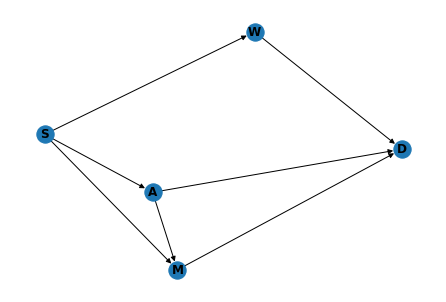

In [17]:
# R code 6.31
# I skipped a lot of code because it mostly came from a simulated data set. The lesson is important, but the code is
# nothing especially new. But it looks like DAGs could be very important. So here we go.

G1=nx.DiGraph()
G1.add_edges_from([("S", "W"), ("S", "M"), ("S", "A"), ("A", "D"), ("A", "M"), ("M", "D"), ("W","D")])
nx.draw(G1, with_labels=True, font_weight='bold')
plt.show();

In [18]:
for path in nx.all_simple_paths(G1, source="S", target="D"):
    print(path)

# all_simple_paths takes into account direction of edges.

['S', 'W', 'D']
['S', 'M', 'D']
['S', 'A', 'D']
['S', 'A', 'M', 'D']


In [19]:
G2=G1.to_undirected()
for path in nx.all_simple_paths(G2, source="S", target="D"):
    print(path)

# to not care about edge directions, conver to an undirected graph and then find paths.

['S', 'W', 'D']
['S', 'M', 'D']
['S', 'M', 'A', 'D']
['S', 'A', 'D']
['S', 'A', 'M', 'D']


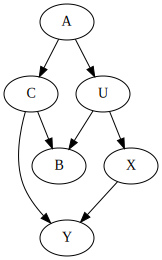

In [32]:
#R code 6.30 - backtracking
#Let's try using CausalGraphicalModel to draw our DAGs
# https://github.com/ijmbarr/causalgraphicalmodels/blob/master/causalgraphicalmodels/cgm.py
# http://www.degeneratestate.org/posts/2018/Mar/24/causal-inference-with-python-part-1-potential-outcomes/
# http://www.degeneratestate.org/posts/2018/Jul/10/causal-inference-with-python-part-2-causal-graphical-models/
DAG = cgm.CausalGraphicalModel(
    nodes = ["A", "B", "C", "U", "X", "Y"],
    edges = [
        ("X","Y"),
        ("U","X"),
        ("U","B"),
        ("A","U"),
        ("A","C"),
        ("C","B"),
        ("C","Y")
    ])
DAG.draw();

In [34]:
x = DAG.get_all_backdoor_adjustment_sets("X", "Y")
x

frozenset({frozenset({'A', 'U'}),
           frozenset({'C'}),
           frozenset({'U'}),
           frozenset({'C', 'U'}),
           frozenset({'A'}),
           frozenset({'A', 'C'}),
           frozenset({'A', 'C', 'U'}),
           frozenset({'B', 'U'}),
           frozenset({'B', 'C'}),
           frozenset({'A', 'B', 'C'}),
           frozenset({'A', 'B', 'U'}),
           frozenset({'B', 'C', 'U'}),
           frozenset({'A', 'B', 'C', 'U'})})

In [36]:
# should generalize this to accept either a DAG or a list of all backdoor adjustment sets

def get_shortest_backdoor_adjustment_sets(all_sets):
    shortest_sets = []
    first_element, *_ = all_sets   # this extracts the first element of the set. I don't understand it.
    min_length = len(first_element)
    for x in all_sets:
        if len(x) < min_length:   # If we've found the shortest set length yet 
            min_length = len(x)   # Set the length as our new min length
            shortest_sets = []    # Clear the shortest sets list
            shortest_sets.append(x) # Add the new set to the list
        elif len(x) == min_length: # If we've found a set equivalent to our min set length
            shortest_sets.append(x) # Just add the set to the list
    return shortest_sets       
    

In [37]:
get_shortest_backdoor_adjustment_sets(x)

[frozenset({'C'}), frozenset({'A'}), frozenset({'U'})]

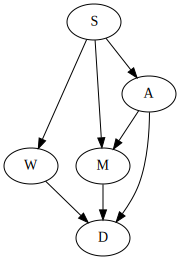

In [74]:
DAG = cgm.CausalGraphicalModel(
    nodes = ["A", "S", "D", "M", "W"],
    edges = [
        ("S","A"),
        ("S","W"),
        ("S","M"),
        ("A","M"),
        ("A","D"),
        ("M","D"),
        ("W","D")
    ])
DAG.draw()

In [76]:
DAG.get_all_backdoor_adjustment_sets("W", "D")
#It would be nice if I wrote a function to get all non-redundant BDAS. As in, don't return
#{M,S} if you've already returned {S}. But that's a problem for another day.

frozenset({frozenset({'S'}),
           frozenset({'M', 'S'}),
           frozenset({'A', 'S'}),
           frozenset({'A', 'M'}),
           frozenset({'A', 'M', 'S'})})

In [77]:
DAG.get_all_independence_relationships()

[('S', 'D', {'A', 'M', 'W'}),
 ('M', 'W', {'S'}),
 ('M', 'W', {'A', 'S'}),
 ('W', 'A', {'S'}),
 ('W', 'A', {'M', 'S'})]

In [89]:
#6H1
# The motivation is that there will be a correlation between Waffle Houses and divorce
# rate if we include age, marriage rate, and divorce rate in our model. See below.

d = pd.read_csv('Data/WaffleDivorce.csv', sep=';', header=0)
d['age_norm'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean())/d.MedianAgeMarriage.std()
d['divorce_norm'] = (d.Divorce - d.Divorce.mean())/d.Divorce.std()
d['marriage_norm'] = (d.Marriage - d.Marriage.mean())/d.Marriage.std()
d['waffles_norm'] = (d.WaffleHouses - d.WaffleHouses.mean())/d.WaffleHouses.std()

In [47]:
with pm.Model() as m_6H1_1:
    alpha = pm.Normal('alpha', mu=0, sd=0.2) 
    beta_marriage = pm.Normal('beta_marriage', mu=0, sd=0.5) 
    beta_age = pm.Normal('beta_age', mu=0, sd=0.5) 
    beta_waffles = pm.Normal('beta_waffles', mu=0, sd=0.5)
    mu = pm.Deterministic('mu', alpha + beta_marriage*d.marriage_norm 
                          + beta_age*d.age_norm + beta_waffles*d.waffles_norm)
    sigma = pm.Exponential('sigma', 1)
    divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.divorce_norm)
    trace_6H1_1 = pm.sample(1000, tune=1000, chains=1) 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_waffles, beta_age, beta_marriage, alpha]
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 644.33it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [48]:
varnames = ['beta_marriage', 'beta_age','beta_waffles']
pm.summary(trace_6H1_1, var_names = varnames, alpha = 0.11).round(2)

# there is a positive correlation between the number of waffle houses and divorce rate.
# the 89th centile is (nearly) entirely positive.

,mean,sd,mc_error,hpd_5.5,hpd_94.5
beta_marriage,-0.04,0.16,0.0,-0.27,0.21
beta_age,-0.57,0.16,0.0,-0.82,-0.32
beta_waffles,0.18,0.12,0.0,-0.03,0.35


In [ ]:
# Based on the DAG, there are several backdoor paths that connect the number of Waffle
# Houses (W) to the divorce rate (D). We can close them all by conditioning the model
# on Southiness S. We don't want anything else in our model, but it doesn't 
# actually matter if M and A are in there. Let's check.


In [90]:
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,age_norm,divorce_norm,marriage_norm,waffles_norm
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.606290,1.654205,0.022644,1.454029
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.686699,1.544364,1.549802,-0.491567
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.204241,0.610716,0.048974,-0.217968
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.410387,2.093569,1.655123,0.131632
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.599857,-0.927058,-0.266989,-0.491567


In [52]:
with pm.Model() as m_6H1_2:
    alpha_south = pm.Normal('alpha_south', mu=0, sd=1) 
    alpha_not_south = pm.Normal('alpha_not_south', mu=0, sd=1)
    beta_waffles = pm.Normal('beta_waffles', mu=0, sd=1)
    mu = pm.Deterministic('mu', alpha_south*d.South + alpha_not_south*(1-d.South)
                         + beta_waffles*d.waffles_norm)
    sigma = pm.Exponential('sigma', 1)
    divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.divorce_norm)
    trace_6H1_2 = pm.sample(1000, tune=1000, chains=1) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta_waffles, alpha_not_south, alpha_south]
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 772.16it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [53]:
varnames = ['alpha_south', 'alpha_not_south', 'beta_waffles', 'sigma']
pm.summary(trace_6H1_2, varnames, alpha=.11).round(3)

# beta_waffles is essentially centered on zero. So no correlation between waffles and divorce, conditioning on south.

,mean,sd,mc_error,hpd_5.5,hpd_94.5
alpha_south,0.470,0.305,0.012,-0.021,0.943
alpha_not_south,-0.188,0.178,0.006,-0.421,0.140
beta_waffles,0.045,0.182,0.007,-0.234,0.336
sigma,0.978,0.108,0.004,0.806,1.139


In [100]:
# Trying it another way. Setting an individual alpha and beta for each category and comparing.
# http://people.duke.edu/~ccc14/sta-663-2016/16C_PyMC3.html

south_codes = pd.Categorical(d['South']).codes

with pm.Model() as m_6H1_3:
    # Hyperpriors - just to make setting individual priors easier. This is useful 
    # when we have loads of categories.
    mu_a = pm.Normal('mu_a', mu=0, sd=10)
    sigma_a = pm.Exponential('sigma_a', 1)
    mu_b = pm.Normal('mu_b', mu=0, sd=10)
    sigma_b = pm.Exponential('sigma_b', 1)

    # Slopes and intercepts for each category
    alpha = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=len(set(south_codes)))
    beta = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=len(set(south_codes)))

    sigma = pm.Exponential('sigma', 1)

    # Model prediction of divorce
    mu = alpha[south_codes] + beta[south_codes] * d.waffles_norm

    # Data likelihood
    divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.divorce_norm)
    
    trace_6H1_3 = pm.sample(10000, tune=1000, chains=1) 
#     start = pm.find_MAP()
#     step = pm.NUTS(scaling=start)
    
# with pm.Model() as m_6H1_3:
#     alpha = pm.Normal('alpha', mu=0, sd=0.2) 
#     beta_south = pm.Normal('beta_marriage', mu=0, sd=0.5) 
#     beta_waffles = pm.Normal('beta_waffles', mu=0, sd=0.5)
#     mu = pm.Deterministic('mu', alpha + beta_waffles*d.waffles_norm)
    
#     divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.divorce_norm)
#     trace_6H1_2 = pm.sample(1000, tune=1000, chains=1) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta, alpha, sigma_b, mu_b, sigma_a, mu_a]
100%|███████████████████████████████████████████████████████████████████████████| 11000/11000 [00:20<00:00, 528.09it/s]
There were 2056 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6287693767573527, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [109]:
pm.summary(trace_6H1_3, alpha=.11).round(3)

,mean,sd,mc_error,hpd_5.5,hpd_94.5
mu_a,0.238,0.666,0.017,-0.618,1.082
mu_b,0.390,0.879,0.026,-0.666,1.766
alpha__0,0.096,0.318,0.011,-0.376,0.616
alpha__1,0.405,0.318,0.012,-0.091,0.896
beta__0,0.664,0.695,0.026,-0.359,1.703
beta__1,0.063,0.190,0.006,-0.263,0.345
sigma_a,0.623,0.630,0.022,0.035,1.325
sigma_b,0.896,0.767,0.026,0.049,1.762
sigma,0.964,0.104,0.003,0.801,1.122


In [153]:
mu_pred[0]

array([-0.58748967,  0.21603205])

In [157]:
trace_6H1_3['alpha'][:,0]

array([0.06747037, 0.85497621, 0.93079399, ..., 0.195612  , 0.05104652,
       0.22356136])

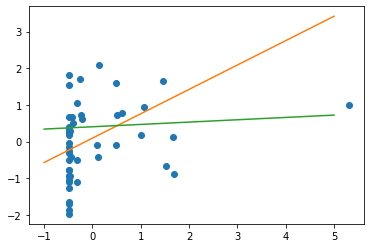

In [159]:
x = np.linspace(-1, 5, 10000)
mu_pred = trace_6H1_3['alpha'][:,0] + trace_6H1_3['beta'][:,0] * x[:,None] 
mu_pred2 = trace_6H1_3['alpha'][:,1] + trace_6H1_3['beta'][:,1] * x[:,None] 
plt.plot(d.waffles_norm, d.divorce_norm, 'o')
plt.plot(x, mu_pred.mean(1))
plt.plot(x, mu_pred2.mean(1))

(10000, 2)

In [ ]:
x = np.linspace(-1, 5, 10000)

mu_pred = trace_5H2['alpha'] + trace_5H2['beta_area'] * x[:,None] 
mu_hpd = pm.hpd(mu_pred.T)
weight_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace_5H2['sigma']).T)

f = plt.figure(figsize=(12,5))

ax_area = f.add_subplot(121)
ax_area.plot(x, mu_pred.mean(1), 'C0')
ax_area.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
ax_area.fill_between(x, weight_hpd[:,0], weight_hpd[:,1], color='C2', alpha=0.25)
ax_area.set_xlabel('Area_s')
ax_area.set_ylabel('Weight_s')

mu_pred = trace_5H2['alpha'] + trace_5H2['beta_size'] * x[:,None] 
mu_hpd = pm.hpd(mu_pred.T)
weight_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace_5H2['sigma']).T)
ax_size = f.add_subplot(122)
ax_size.plot(x, mu_pred.mean(1), 'C0');  
ax_size.fill_between(x, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
ax_size.fill_between(x, weight_hpd[:,0], weight_hpd[:,1], color='C2', alpha=0.25)

ax_size.set_xlabel('Size_s')
ax_size.set_ylabel('Weight_s');

In [54]:
# Trying it another way.
# https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501

south_codes = pd.Categorical(d['South']).codes

with pm.Model() as m_6H1_4:
    alpha = pm.Normal('alpha', mu=0, sd=1, shape=len(set(south_codes)))
    beta = pm.Normal('beta', mu=0, sd=1, shape=len(set(south_codes)))
    sigma = pm.HalfNormal('sigma', sd=1)
    mu = pm.Deterministic('mu', alpha[south_codes])
    # Data likelihood
    divorce = pm.Normal('divorce', mu=mu[south_codes], sd=sigma[south_codes], 
                        observed=d.divorce_norm)
    
    trace_6H1_4 = pm.sample(10000, tune=1000, chains=1) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]
100%|██████████████████████████████████████████████████████████████████████████| 11000/11000 [00:07<00:00, 1421.67it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [55]:
pm.summary(trace_6H1_4, alpha=.11).round(3)
# All this shows is that we get different values of mu (mean marriage) for different
# values of southiness. It doesn't 'control' for southiness in any way.

,mean,sd,mc_error,hpd_5.5,hpd_94.5
mu__0,-0.206,0.162,0.001,-0.457,0.060
mu__1,0.514,0.252,0.002,0.130,0.935
sigma__0,0.987,0.119,0.001,0.793,1.164
sigma__1,0.945,0.190,0.002,0.665,1.234
